In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import torchvision
import matplotlib.pyplot as plt

# Variational Autoencoder (VAE)
## Introduction:
<p>Variational Autoencoder (VAE) is a type of generative model that can learn a low-dimensional representation of the data and generate new data samples from the learned latent space. VAEs are a type of autoencoder, which is a neural network architecture that can learn to encode the input data into a low-dimensional representation and then decode it back to the original data.</p>

### Encoder: 
The first step in implementing a VAE is to design an encoder neural network that maps the input data to a distribution in the latent space. The encoder typically consists of several layers of neurons that apply linear and non-linear transformations to the input data.
The encoder takes an input x and maps it to the mean mu and standard deviation log_var of a normal distribution in the latent space. The encoder consists of two fully connected layers with ReLU activation function followed by two output layers for mu and log_var. The formulas for the encoder are:
### Latent Space: 
The latent space is a low-dimensional representation of the input data that captures the most important features of the data. The size of the latent space is a hyperparameter that needs to be chosen based on the complexity of the data and the desired level of compression.
Sampling: After the encoder maps the input data to the latent space, a sample is drawn from the distribution in the latent space. This sample is used as input to the decoder, which generates the output data.
### Decoder: 
The decoder is a neural network that takes the sample from the latent space and maps it back to the original data space. The decoder typically consists of several layers of neurons that apply linear and non-linear transformations to the sample.
The decoder takes a point z from the latent space and maps it back to the original input space. The decoder consists of two fully connected layers with ReLU activation function followed by an output layer with sigmoid activation function
### Loss Function: 
The loss function in VAE consists of two parts: the reconstruction loss and the KL divergence loss. The reconstruction loss measures the difference between the input data and the reconstructed output, while the KL divergence loss regularizes the learned distribution in the latent space.
The loss function for VAE consists of two parts: the reconstruction loss and the KL divergence loss. The reconstruction loss measures the difference between the input x and the output x_hat obtained from the decoder. The KL divergence loss measures the difference between the latent distribution and the standard normal distribution.



## Implementation of VAE

In [3]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 2 * latent_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256 * 4 * 4),
            nn.Unflatten(-1, (256, 4, 4)),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid(),
        )

    def encode(self, x):
        x = self.encoder(x)
        mu, logvar = x.chunk(2, dim=-1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar

## Implementation of VAE loss function

In [4]:
def vae_loss(x, x_hat, mu, logvar):
    # reconstruction loss
    recon_loss = F.binary_cross_entropy(x_hat, x, reduction='sum')

    # regularization loss
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + kl_div

## Loading data

In [6]:
train_data = MNIST(root='data', train=True, transform=ToTensor(), download=True)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

100.0%


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw



100.0%


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw



100.0%


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw



100.0%

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



In [35]:
one_sample=None
for x,y in (train_loader):
    one_sample=x
    break
    

In [37]:
torchvision.utils.save_image(x, 'train_data.png', nrow=8, normalize=True)

![Alt text](train_data.png "Title")

In [24]:
loss_list=[]

## Training: 
The VAE is trained by minimizing the loss function with respect to the model parameters using stochastic gradient descent. The training process consists of the following steps:
## Forward pass: 
The input x is passed through the encoder to obtain mu and log_var. A point z is then sampled from the normal distribution in the latent space using mu and log_var. The point z is passed through the decoder to obtain x_hat.
## Loss calculation: 
The reconstruction loss and the KL divergence loss are calculated using x, x_hat, mu, and log_var.
## Backward pass: 
The gradients of the loss with respect to the model parameters are calculated using backpropagation.
## Parameter update: 
The model parameters are updated using the gradients and the chosen optimizer.


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE(latent_dim=20).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 40
for epoch in range(epochs):
    running_loss = 0.0
    for x, _ in train_loader:
        x = x.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        x_resized = F.interpolate(x, size=(32, 32), mode='bilinear', align_corners=False)
        x=x_resized
        # forward + backward + optimize
        x_hat, mu, logvar = model(x)
        loss = vae_loss(x, x_hat, mu, logvar)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    loss_list.append(running_loss)
    

 

In [29]:
torch.save(model, "vae_model")

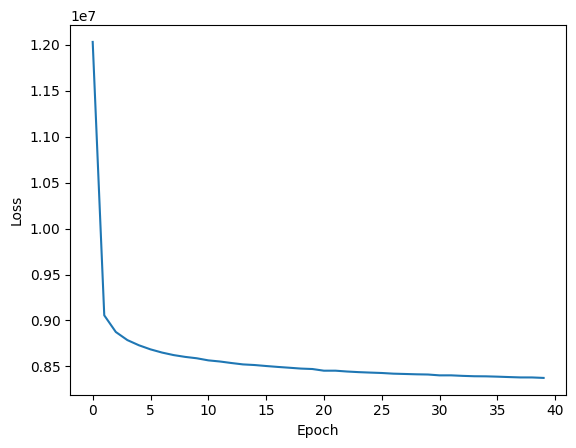

In [28]:

epochs = range(len(loss_list))
plt.plot(epochs, loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [20]:
with torch.no_grad():
    z = torch.randn(64, 20).to(device)
    print(z.shape)
    x_hat = model.decode(z).cpu()
    print(x_hat.shape)
    # save the generated images to a file
    torchvision.utils.save_image(x_hat, 'generated_images3.png', nrow=8, normalize=True)

torch.Size([64, 20])
torch.Size([64, 1, 32, 32])


![Alt text](generated_images3.png "Title")